# Exploratory Data Analysis

First please make sure to run init.sh--this sets up the docker container with the database we'll be querying in this notebook.

In this notebook we'll be taking a look at the overall structure of the data and checking for any obvious patterns or problems present.

We'll use psycopg2 to connect to our database, pandas' sql module to query the data into dataframes, and matplotlib/seaborn to visualize the results. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.io.sql as pd_sql
import psycopg2 as pg
from psycopg2 import sql, extras
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from sklearn.model_selection import train_test_split
import pdb

In [4]:
connection_args = {
    'host': "localhost",
    'user': "docker",
    'dbname': 'trafficflow', # Database we are connecting to
    'port': 9999,
    'connect_timeout': 0
}

index=["timestamp","tablename","dst_port"]
conn = pg.connect(**connection_args)
cursor = conn.cursor()

Each row in our dataset is a summary of a bi-directional flow of packets between two endpoints (IP/port pairs) in a computer network. Our goal is to classify those flows as one of 9 different attacks. Our dataset is too large to fit into RAM, so, outside of a distributed ML model, we have two options: 1) discard enough features to fit all the observations in RAM, or 2) stream data in batches to a classifier capable of online learning,

Let's start with the first approach. Let's make our target dataframe size 2 gigabytes. We have roughly 16 million rows. Assuming each feature is 8 bytes, we can fit about 14 features in RAM. As a first step, let's remove features with low variance.

In [23]:
#get column names and data types for use in our query
cursor.execute("""
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'trafficdata';""")

col_names = cursor.fetchall()

query = "SELECT {} FROM trafficdata".format(
    ', '.join(
        [f"VAR_SAMP({col[0]}) AS {col[0]}" for col in col_names if col[1] not in ['text', 'timestamp without time zone']])
                    )
variances = pd.read_sql_query(query, conn).transpose()[0]
variances.sort_values().head(10)

fwd_urg_flags     0.000164
cwe_flag_count    0.000164
fin_flag_cnt      0.004772
urg_flag_cnt      0.039973
syn_flag_cnt      0.041969
fwd_psh_flags     0.041969
rst_flag_cnt      0.152280
ece_flag_cnt      0.152280
ack_flag_cnt      0.221642
psh_flag_cnt      0.238354
Name: 0, dtype: float64

It looks like some of these features are constant! Obviously these won't be good features when building our model, so we might as well throw them out. 

In [4]:
for col in variances[variances==0].index:
    cursor.execute(f"""SELECT COUNT(DISTINCT({col})) FROM trafficdata""")
    if cursor.fetchall()[0][0]==1:
        cursor.execute(f"ALTER TABLE trafficdata DROP COLUMN {col}")
        conn.commit()    

Let's wait before discarding any features with non-zero variance. Another way to gauge whether a feature is useful is to leverage a model. We'll build a RandomForestClassifier and then use the 15 best features as defined by the model's feature importances.

First let's pull a random sample from our database.

In [19]:
sample = pd_sql.read_sql_query(
    """SELECT * FROM trafficdata TABLESAMPLE BERNOULLI(4)
    UNION (SELECT * FROM trafficdata WHERE label = 'SQL Injection' LIMIT 10)
    UNION (SELECT * FROM trafficdata WHERE label = 'Brute Force -XSS')
    """, conn, index_col=index)
# flow_byts_s has some np.inf values, so we replace those with NaNs and then impute 
# with the max column value.
sample = sample.replace(np.inf, pd.NA)
sample = sample.fillna(sample.max())

The next move is to assess the distribution of classes in our dataset. Class imbalance will require further transformations. 

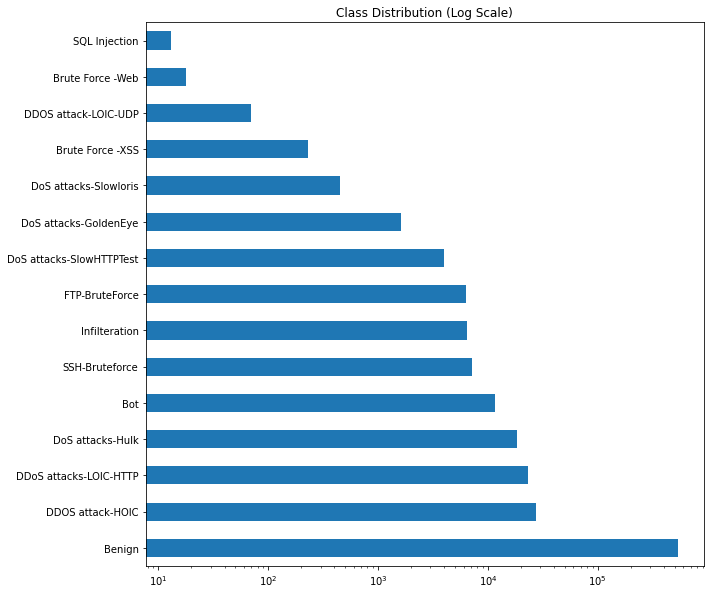

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
sample['label'].value_counts().plot(kind='barh',logx=True, ax=ax, title='Class Distribution (Log Scale)')

As we can see, there is a pretty staggering class imbalance--the number of benign observations is almost two orders of magnitude greater than next most numerous class. Meanwhile, the least-represented class has less than 50 observations.

We have plenty of observations, so the most obvious step is undersampling the majority class. In order to further balance the classes, we'll also oversample some of the less frequent classes by creating synthetic samples. Let's aim to bring all our observations in line with the median class. For the classes with very few observations, we'll only oversample by a factor of 3 to prevent overfitting. 

In [13]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

def oversampling_strat(y: 'numpy array of labels', max_multiple=3)-> dict:
    """
    Specifies target number of samples for resampled classes. If a class has fewer observations than
    target_num/max_multiple, returns the number of that class's observations times max_multiple.
    """
    target_nums = {}
    class_nums = np.unique(y, return_counts=True)
    target_num = int(class_nums[1].mean())
    for idx, label in enumerate(class_nums[0]):
        count = class_nums[1][idx]
        if count>=target_num:
            target_nums[label]=count
        elif count*max_multiple < target_num:
            target_nums[label]=count*max_multiple
        else:
            target_nums[label]=target_num
    return target_nums

def undersampling_strat(y: 'numpy array of labels')-> dict:
    """
    Matches majority class to second-most-frequent class.
    """
    class_nums = np.unique(y, return_counts=True)
    sorted_indices = class_nums[1].argsort()
    majority_class = class_nums[0][sorted_indices[-1]]
    target_nums = dict(zip(*class_nums))
    target_nums[majority_class]=class_nums[1][sorted_indices[-2]]
    return target_nums

/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [8]:
oversampler = SMOTE(sampling_strategy=oversampling_strat, n_jobs=-1)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_strat)
estimator = RandomForestClassifier(n_jobs=-1, verbose=2)
pipe = make_pipeline(undersampler, oversampler, estimator)

/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

Now that we've established our strategy for balancing our data's class distribution, it's time to fit our model. We'll use a random search to optimize our hyperparameters and then use the best estimator to calculate feature importances. Since we don't plan on using this as our final model, we won't bother with splitting into test and train subsets, and will rely on cross-validation to assess how well our model generalizes.

In [27]:

And separately but on a related note, doesn't the US military sell plenty ofrom sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(3)
params = {'randomforestclassifier__max_features': range(2, 10),
          'randomforestclassifier__min_impurity_decrease': np.linspace(0, 1e-6, 50),
          'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample'],
          'randomforestclassifier__min_samples_split': range(2, 10)
          }

RS = RandomizedSearchCV(pipe, param_distributions=params,
                        n_iter=15, cv=cv, scoring='f1_macro', random_state=42)
RS.fit(sample.drop('label', axis=1), sample['label'])
feature_selector = RS.best_estimator_

NameError: name 'sample' is not defined

Stored 'best_features' (Series)


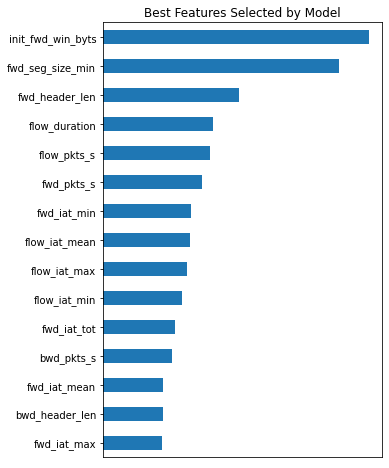

In [22]:
feature_importances = pd.Series(dict(zip(sample.columns, RS.best_estimator_['randomforestclassifier'].feature_importances_)))
best_features = feature_importances.sort_values().tail(14)
# store in case notebook crashes
%store best_features
best_features.plot(kind='barh', figsize=(5,8), xticks=[], title = "Best Features Selected by Model");

Now that we have our candidates for best features, it's time to train our final model. We'll delete all global variables first to make sure we have enough memory available, then pull from our database in chunks. Then 

In [33]:
def querydb(query, connection):
    cursor = connection.cursor(name="my_cursor")
    cursor.execute(query)
    first = True
    while True:
        rows = cursor.fetchmany(size=500_000)
        if len(rows)==0:
            break
        if first:
            data = np.array(rows)
            first=False
        else:
            data = np.concatenate([data, np.array(rows)])
            
        print(data.shape, data.nbytes/1e9) #number of observations, size of sample in gigabytes
    cursor.close()
    return data

In [5]:
%reset
%store -r best_features
#convert string labels to integers for memory efficiency
query = """SELECT {}, CASE
        WHEN label='Benign' THEN 0
        WHEN label='SQL Injection' THEN 1
        WHEN label='Brute Force -Web' THEN 2
        WHEN label='DoS attacks-Slowloris' THEN 3
        WHEN label='DoS attacks-GoldenEye' THEN 4
        WHEN label='DoS attacks-SlowHTTPTest' THEN 5
        WHEN label='DDOS attack-LOIC-UDP' THEN 6
        WHEN label='Brute Force -XSS' THEN 7
        WHEN label='FTP-BruteForce' THEN 8
        WHEN label='Infilteration' THEN 9
        WHEN label='SSH-Bruteforce' THEN 10
        WHEN label='Bot' THEN 11
        WHEN label='DoS attacks-Hulk' THEN 12
        WHEN label='DDoS attacks-LOIC-HTTP' THEN 13
        WHEN label='DDOS attack-HOIC' THEN 14
        END as label
        FROM trafficdata""".format(', '.join(best_features.index[:14]))
sample = querydb(query, conn)

(500000, 15) 0.06
(1000000, 15) 0.12
(1500000, 15) 0.18
(2000000, 15) 0.24
(2500000, 15) 0.3
(3000000, 15) 0.36
(3500000, 15) 0.42
(4000000, 15) 0.48
(4500000, 15) 0.54
(5000000, 15) 0.6
(5500000, 15) 0.66
(6000000, 15) 0.72
(6500000, 15) 0.78
(7000000, 15) 0.84
(7500000, 15) 0.9
(8000000, 15) 0.96
(8500000, 15) 1.02
(9000000, 15) 1.08
(9500000, 15) 1.14
(10000000, 15) 1.2
(10500000, 15) 1.26
(11000000, 15) 1.32
(11500000, 15) 1.38
(12000000, 15) 1.44
(12500000, 15) 1.5
(13000000, 15) 1.56
(13500000, 15) 1.62
(14000000, 15) 1.68
(14500000, 15) 1.74
(15000000, 15) 1.8
(15500000, 15) 1.86
(16000000, 15) 1.92
(16232929, 15) 1.94795148


In [6]:
sample = np.ma.masked_invalid(sample) 
sample = sample.filled() # impute np.inf with large numbers

In [7]:
X_train, X_test, y_train, y_test = train_test_split(sample[:,:-1], sample[:,-1], stratify=sample[:,-1])
del(sample)


In [8]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

def oversampling_strat(y: 'numpy array of labels', max_multiple=3)-> dict:
    """
    Specifies target number of samples for resampled classes. If a class has fewer observations than
    target_num/max_multiple, returns the number of that class's observations times max_multiple.
    """
    target_nums = {}
    class_nums = np.unique(y, return_counts=True)
    target_num = int(class_nums[1].mean())
    for idx, label in enumerate(class_nums[0]):
        count = class_nums[1][idx]
        if count>=target_num:
            target_nums[label]=count
        elif count*max_multiple < target_num:
            target_nums[label]=count*max_multiple
        else:
            target_nums[label]=target_num
    return target_nums

def undersampling_strat(y: 'numpy array of labels')-> dict:
    """
    Matches majority class to second-most-frequent class.
    """
    class_nums = np.unique(y, return_counts=True)
    sorted_indices = class_nums[1].argsort()
    majority_class = class_nums[0][sorted_indices[-1]]
    target_nums = dict(zip(*class_nums))
    target_nums[majority_class]=class_nums[1][sorted_indices[-2]]
    return target_nums

/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alex/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [9]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
undersampler = RandomUnderSampler(sampling_strategy=undersampling_strat)

oversampler = SMOTE(sampling_strategy=oversampling_strat, n_jobs=-1)
estimator = RandomForestClassifier(n_jobs=-1, verbose=2)
pipe = make_pipeline(undersampler, oversampler, estimator)


cv = StratifiedKFold(3)
params = {'randomforestclassifier__max_features': range(2, 10),
          'randomforestclassifier__min_impurity_decrease': np.linspace(0, 1e-6, 50),
          'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample'],
          'randomforestclassifier__min_samples_split': range(2, 10)
          }

RS = RandomizedSearchCV(pipe, param_distributions=params,
                        n_iter=20, scoring=['neg_log_loss','f1_weighted','f1_macro', 'roc_auc_ovo', 'roc_auc_ovr_weighted'],
                        refit='f1_weighted', random_state=42, cv=cv, 
                        verbose=2)

In [10]:
RS.fit(X_train, y_train)

import pickle
#save model for later use
with open('model.pkl', 'wb') as pkl:
    pickle.dump(RS, pkl)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/alex/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   33.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.7s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=balanced_subsample, total= 6.0min
[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.6s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=balanced_subsample, total= 6.0min
[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.6s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=balanced_subsample, total= 6.0min
[CV] randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=1.4285714285714285e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.7s finished


[CV]  randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=1.4285714285714285e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None, total= 5.5min
[CV] randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=1.4285714285714285e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   33.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.8s finished


[CV]  randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=1.4285714285714285e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None, total= 5.5min
[CV] randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=1.4285714285714285e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.9s finished


[CV]  randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=1.4285714285714285e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None, total= 5.5min
[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.2s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.3min
[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.5s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.3min
[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.3s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.3min
[CV] randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.0s finished


[CV]  randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced, total= 6.5min
[CV] randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.9s finished


[CV]  randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced, total= 6.4min
[CV] randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.8s finished


[CV]  randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced, total= 6.4min
[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=3.265306122448979e-07, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.2s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=3.265306122448979e-07, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=balanced, total= 8.2min
[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=3.265306122448979e-07, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.2s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=3.265306122448979e-07, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=balanced, total= 8.2min
[CV] randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=3.265306122448979e-07, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.9s finished


[CV]  randomforestclassifier__min_samples_split=8, randomforestclassifier__min_impurity_decrease=3.265306122448979e-07, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=balanced, total= 8.0min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=6.734693877551019e-07, randomforestclassifier__max_features=9, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.3s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=6.734693877551019e-07, randomforestclassifier__max_features=9, randomforestclassifier__class_weight=balanced, total= 8.5min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=6.734693877551019e-07, randomforestclassifier__max_features=9, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.2s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=6.734693877551019e-07, randomforestclassifier__max_features=9, randomforestclassifier__class_weight=balanced, total= 8.4min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=6.734693877551019e-07, randomforestclassifier__max_features=9, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.6s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=6.734693877551019e-07, randomforestclassifier__max_features=9, randomforestclassifier__class_weight=balanced, total= 8.5min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   33.1s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None, total= 4.9min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.9s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None, total= 4.9min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   33.0s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=1.6326530612244896e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None, total= 4.8min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=6.122448979591837e-08, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   35.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   35.3s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=6.122448979591837e-08, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced, total= 6.5min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=6.122448979591837e-08, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   35.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.8s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=6.122448979591837e-08, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced, total= 6.5min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=6.122448979591837e-08, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   35.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   35.0s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=6.122448979591837e-08, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced, total= 6.6min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=9.591836734693876e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.0s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=9.591836734693876e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.1min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=9.591836734693876e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.0s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=9.591836734693876e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.1min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=9.591836734693876e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.1s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=9.591836734693876e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.0min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=8.163265306122447e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.9s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=8.163265306122447e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced_subsample, total= 6.8min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=8.163265306122447e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.2s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=8.163265306122447e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced_subsample, total= 6.8min
[CV] randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=8.163265306122447e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.9s finished


[CV]  randomforestclassifier__min_samples_split=4, randomforestclassifier__min_impurity_decrease=8.163265306122447e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced_subsample, total= 6.8min
[CV] randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=2.040816326530612e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   31.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   31.3s finished


[CV]  randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=2.040816326530612e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=None, total= 6.6min
[CV] randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=2.040816326530612e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   31.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   32.1s finished


[CV]  randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=2.040816326530612e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=None, total= 6.7min
[CV] randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=2.040816326530612e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   31.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   31.3s finished


[CV]  randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=2.040816326530612e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=None, total= 6.6min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=9.387755102040815e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.0s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=9.387755102040815e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None, total= 4.4min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=9.387755102040815e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.4s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=9.387755102040815e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None, total= 4.3min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=9.387755102040815e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.7s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=9.387755102040815e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=None, total= 4.3min
[CV] randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=3.6734693877551015e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.8s finished


[CV]  randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=3.6734693877551015e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=balanced_subsample, total= 5.2min
[CV] randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=3.6734693877551015e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.6s finished


[CV]  randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=3.6734693877551015e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=balanced_subsample, total= 5.2min
[CV] randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=3.6734693877551015e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.8s finished


[CV]  randomforestclassifier__min_samples_split=7, randomforestclassifier__min_impurity_decrease=3.6734693877551015e-07, randomforestclassifier__max_features=3, randomforestclassifier__class_weight=balanced_subsample, total= 5.2min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=8.163265306122448e-08, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.7s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=8.163265306122448e-08, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=None, total= 8.2min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=8.163265306122448e-08, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.7s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=8.163265306122448e-08, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=None, total= 8.3min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=8.163265306122448e-08, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.7s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=8.163265306122448e-08, randomforestclassifier__max_features=8, randomforestclassifier__class_weight=None, total= 8.1min
[CV] randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=2.6530612244897955e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.9s finished


[CV]  randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=2.6530612244897955e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.6min
[CV] randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=2.6530612244897955e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.6s finished


[CV]  randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=2.6530612244897955e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.5min
[CV] randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=2.6530612244897955e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.6s finished


[CV]  randomforestclassifier__min_samples_split=9, randomforestclassifier__min_impurity_decrease=2.6530612244897955e-07, randomforestclassifier__max_features=7, randomforestclassifier__class_weight=balanced, total= 7.4min
[CV] randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=6.326530612244898e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.8s finished


[CV]  randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=6.326530612244898e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced, total= 6.6min
[CV] randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=6.326530612244898e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.7s finished


[CV]  randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=6.326530612244898e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced, total= 6.6min
[CV] randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=6.326530612244898e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.7s finished


[CV]  randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=6.326530612244898e-07, randomforestclassifier__max_features=6, randomforestclassifier__class_weight=balanced, total= 6.6min
[CV] randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=4.081632653061224e-08, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   36.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   36.8s finished


[CV]  randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=4.081632653061224e-08, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced_subsample, total= 4.9min
[CV] randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=4.081632653061224e-08, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   36.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   37.0s finished


[CV]  randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=4.081632653061224e-08, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced_subsample, total= 4.9min
[CV] randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=4.081632653061224e-08, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced_subsample 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   36.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   36.5s finished


[CV]  randomforestclassifier__min_samples_split=6, randomforestclassifier__min_impurity_decrease=4.081632653061224e-08, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced_subsample, total= 4.9min
[CV] randomforestclassifier__min_samples_split=2, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.5s finished


[CV]  randomforestclassifier__min_samples_split=2, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None, total= 4.9min
[CV] randomforestclassifier__min_samples_split=2, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.3s finished


[CV]  randomforestclassifier__min_samples_split=2, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None, total= 4.9min
[CV] randomforestclassifier__min_samples_split=2, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.9s finished


[CV]  randomforestclassifier__min_samples_split=2, randomforestclassifier__min_impurity_decrease=9.795918367346939e-07, randomforestclassifier__max_features=4, randomforestclassifier__class_weight=None, total= 4.9min
[CV] randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=3.877551020408163e-07, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.5s finished


[CV]  randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=3.877551020408163e-07, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced, total= 6.1min
[CV] randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=3.877551020408163e-07, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.1s finished


[CV]  randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=3.877551020408163e-07, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced, total= 6.2min
[CV] randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=3.877551020408163e-07, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.8s finished


[CV]  randomforestclassifier__min_samples_split=5, randomforestclassifier__min_impurity_decrease=3.877551020408163e-07, randomforestclassifier__max_features=5, randomforestclassifier__class_weight=balanced, total= 6.0min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.4s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced, total= 4.2min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.0s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced, total= 4.2min
[CV] randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.1s finished


[CV]  randomforestclassifier__min_samples_split=3, randomforestclassifier__min_impurity_decrease=4.6938775510204074e-07, randomforestclassifier__max_features=2, randomforestclassifier__class_weight=balanced, total= 4.2min


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 377.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.0s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished


NameError: name 'pickle' is not defined

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98   3371174
         1.0       1.00      0.41      0.58        22
         2.0       0.14      0.71      0.23       153
         3.0       0.90      0.97      0.94      2747
         4.0       0.96      1.00      0.98     10377
         5.0       0.76      0.52      0.62     34973
         6.0       0.84      0.96      0.90       432
         7.0       0.91      0.54      0.68        57
         8.0       0.72      0.88      0.79     48340
         9.0       0.17      0.36      0.23     40484
        10.0       1.00      1.00      1.00     46897
        11.0       0.88      0.99      0.93     71548
        12.0       0.97      1.00      0.98    115478
        13.0       0.91      1.00      0.95    144048
        14.0       0.91      0.97      0.94    171503

    accuracy                           0.96   4058233
   macro avg       0.80      0.82      0.78   4058233
weighted avg       0.97   

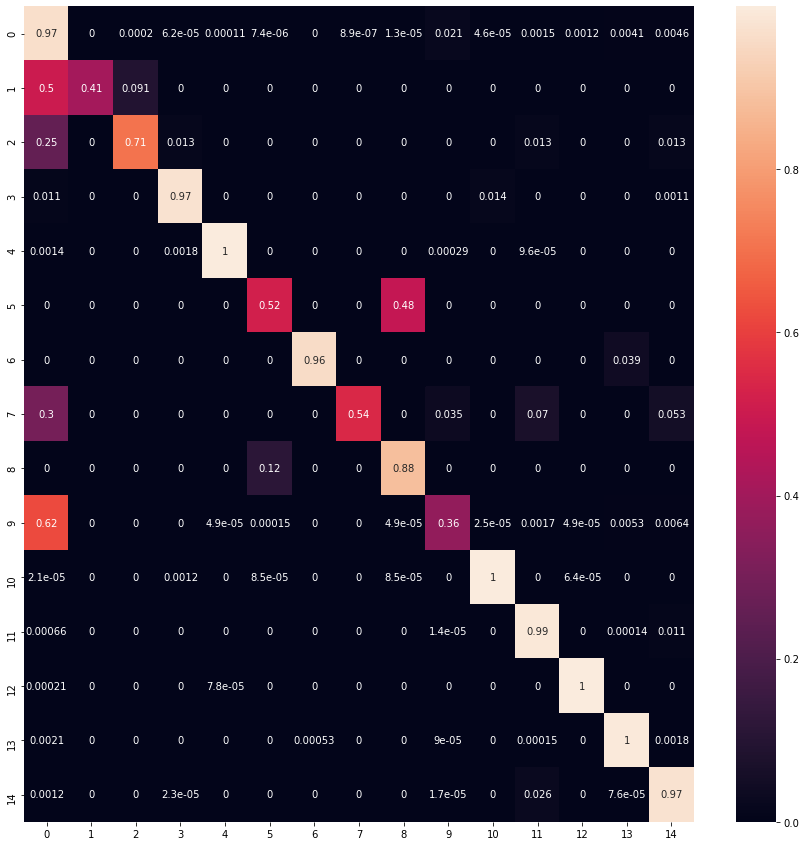

In [18]:
from sklearn.metrics import f1_score, confusion_matrix
#y_hat = RS.predict(X_test)
print(classification_report(y_test, y_hat))
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(confusion_matrix(y_test, y_hat, normalize='true'), annot=True,ax=ax)

In [32]:
scores_df = pd.DataFrame(RS.cv_results_)
scores = [col for col in scores_df if 'mean_test' in col or "rank" in col]
scores_df[scores]
f1_macro_params = scores_df.sort_values('mean_test_f1_macro').loc[0,"params"]

AttributeError: 'Pipeline' object has no attribute 'et_params'

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100building tree 13 of 100
building tree 14 of 100

building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100building tree 32 of 100

building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100building tree 44 of 100
building tree 45 of 100

building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100building tree 54 of 100

building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.6s finished


              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98   3371174
         1.0       1.00      0.41      0.58        22
         2.0       0.14      0.71      0.23       153
         3.0       0.90      0.97      0.94      2747
         4.0       0.96      1.00      0.98     10377
         5.0       0.76      0.52      0.62     34973
         6.0       0.84      0.96      0.90       432
         7.0       0.91      0.54      0.68        57
         8.0       0.72      0.88      0.79     48340
         9.0       0.17      0.36      0.23     40484
        10.0       1.00      1.00      1.00     46897
        11.0       0.88      0.99      0.93     71548
        12.0       0.97      1.00      0.98    115478
        13.0       0.91      1.00      0.95    144048
        14.0       0.91      0.97      0.94    171503

    accuracy                           0.96   4058233
   macro avg       0.80      0.82      0.78   4058233
weighted avg       0.97   

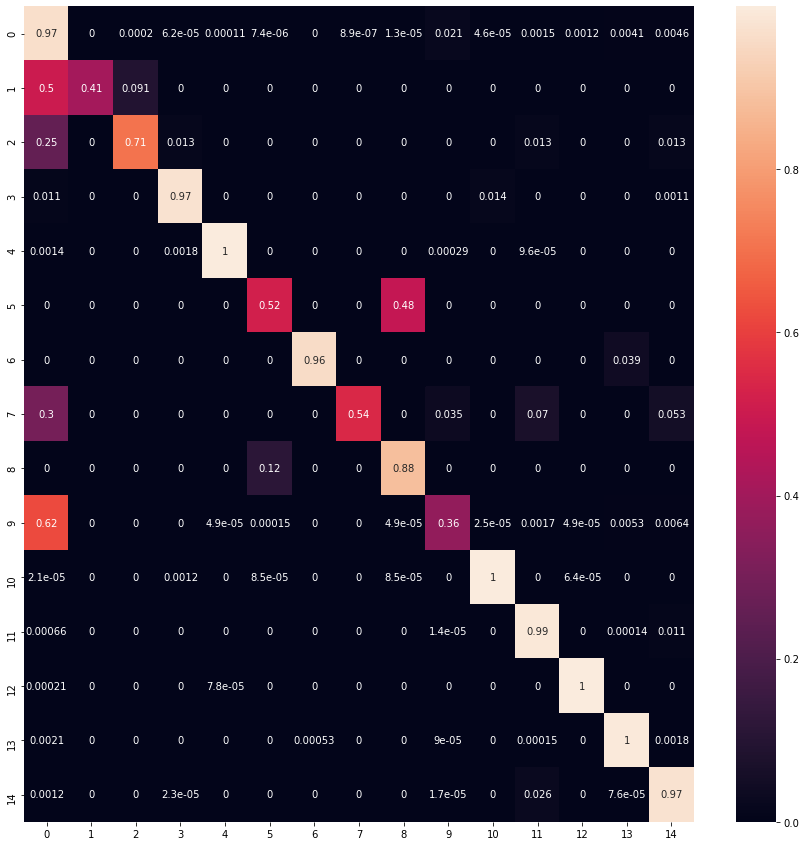

In [37]:
pipe.set_params(**f1_macro_params)
pipe.fit(X_train, y_train)

y_hat_macro  = pipe.predict(X_test)
print(classification_report(y_test, y_hat))
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(confusion_matrix(y_test, y_hat, normalize='true'), annot=True,ax=ax)

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85   3371174
         1.0       0.00      0.55      0.00        22
         2.0       0.00      0.81      0.00       153
         3.0       0.68      0.98      0.80      2747
         4.0       0.95      1.00      0.97     10377
         5.0       0.76      0.52      0.62     34973
         6.0       0.73      0.99      0.84       432
         7.0       0.00      0.60      0.00        57
         8.0       0.72      0.88      0.79     48340
         9.0       0.03      0.61      0.06     40484
        10.0       1.00      1.00      1.00     46897
        11.0       0.87      0.99      0.93     71548
        12.0       0.97      1.00      0.98    115478
        13.0       0.91      0.99      0.95    144048
        14.0       0.91      0.97      0.94    171503

    accuracy                           0.78   4058233
   macro avg       0.64      0.84      0.65   4058233
weighted avg       0.97   

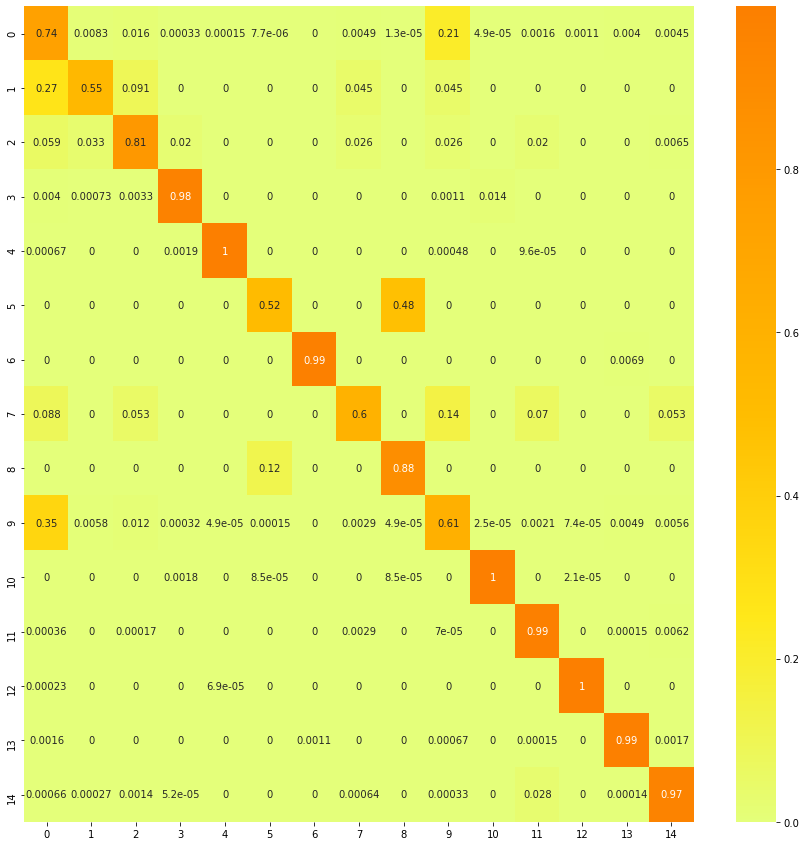

In [46]:
print(classification_report(y_test, y_hat_macro))
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(confusion_matrix(y_test, y_hat_macro, normalize='true'), annot=True,ax=ax, cmap='Wistia');